Enter loan amount:  250000
Enter income:  60000
Enter property value:  300000
Enter co-applicant (yes or no):  yes
Enter amount of debt:  0


Predicted outcome: Approved
Approval probability: 55.64%


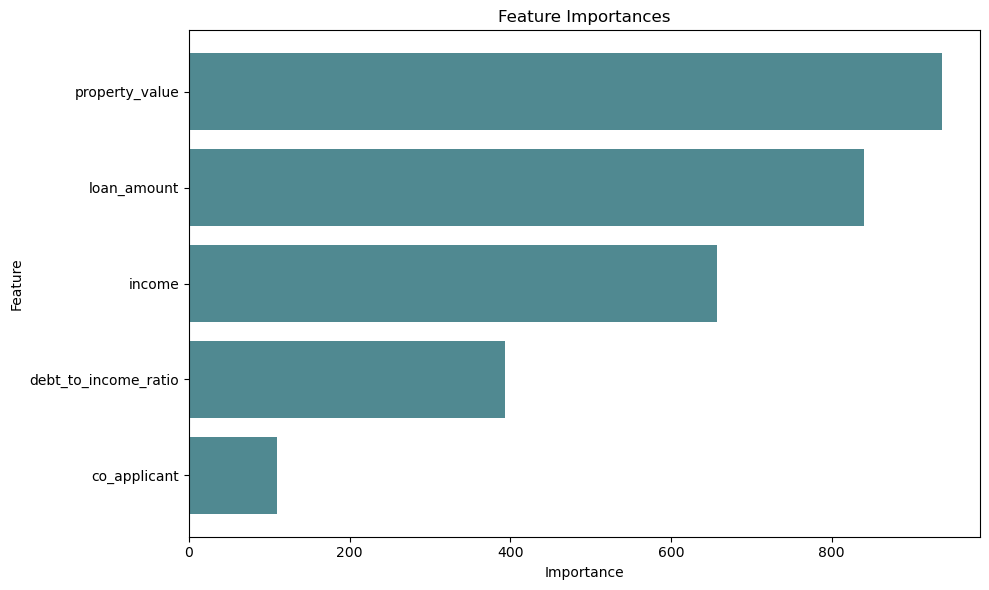

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt

def load_model(model_path):
    """Load a machine learning model from a pickle file."""
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
    return model

def load_scaler(scaler_path):
    """Load a scaler from a pickle file."""
    with open(scaler_path, 'rb') as file:
        scaler = pickle.load(file)
    return scaler

def calculate_debt_to_income_ratio(debt, income):
    """Calculate the debt to income ratio."""
    return debt / income

def preprocess_input(user_input, feature_names, scaler):
    """Preprocess the user input using the provided scaler."""
    # Create a DataFrame with the user input in the correct order
    input_df = pd.DataFrame([user_input], columns=feature_names)
    # Scale the input data
    input_scaled = scaler.transform(input_df)
    return input_scaled

def categorize_debt_to_income_ratio(dti_ratio):
    """Categorize the debt to income ratio into the appropriate bin."""
    categories = {
        'debt_to_income_ratio_50%-<60%': 0,
        'debt_to_income_ratio_>60%': 0,
        'debt_to_income_ratio_40%-<50%': 0,
        'debt_to_income_ratio_30%-<40%': 0,
        'debt_to_income_ratio_<20%': 0
    }
    
    if dti_ratio >= 0.6:
        categories['debt_to_income_ratio_>60%'] = 1
    elif 0.5 <= dti_ratio < 0.6:
        categories['debt_to_income_ratio_50%-<60%'] = 1
    elif 0.4 <= dti_ratio < 0.5:
        categories['debt_to_income_ratio_40%-<50%'] = 1
    elif 0.3 <= dti_ratio < 0.4:
        categories['debt_to_income_ratio_30%-<40%'] = 1
    elif dti_ratio < 0.2:
        categories['debt_to_income_ratio_<20%'] = 1
    
    return categories

def predict_user_input(model, user_input, feature_names, scaler):
    """Predict the outcome based on user input using the loaded model."""
    # Calculate the debt to income ratio
    dti_ratio = calculate_debt_to_income_ratio(user_input['debt'], user_input['income'])
    
    # Categorize the debt to income ratio
    dti_categories = categorize_debt_to_income_ratio(dti_ratio)
    
    # Merge the user input with the categorized debt to income ratio
    for category in dti_categories:
        user_input[category] = dti_categories[category]
    
    # Remove 'debt' from user_input as it's not part of the features
    user_input.pop('debt', None)
    
    # Ensure all expected features are present in the user input
    for feature in feature_names:
        if feature not in user_input:
            user_input[feature] = 0  # Default value if the feature is missing
    
    # Preprocess the user input
    input_scaled = preprocess_input(user_input, feature_names, scaler)
    
    # Make a prediction
    prediction = model.predict(input_scaled)
    prediction_proba = model.predict_proba(input_scaled)
    
    approval_proba = prediction_proba[0][1] * 100  # Probability of approval
    
    return 'Approved' if prediction[0] == 1 else 'Denied', approval_proba

def plot_feature_importance(model, feature_names):
    """Plot the feature importance of the model."""
    importances = model.feature_importances_
    feature_importances = dict(zip(feature_names, importances))
    
    # Aggregate the debt to income ratio categories
    dti_categories = [
        'debt_to_income_ratio_50%-<60%', 'debt_to_income_ratio_>60%',
        'debt_to_income_ratio_40%-<50%', 'debt_to_income_ratio_30%-<40%',
        'debt_to_income_ratio_<20%'
    ]
    dti_importance = sum(feature_importances.pop(cat) for cat in dti_categories if cat in feature_importances)
    feature_importances['debt_to_income_ratio'] = dti_importance
    
    # Sort the features by importance
    sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
    features, importances = zip(*sorted_features)
    
    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.barh(range(len(importances)), importances, align='center', color='#508991')
    plt.yticks(range(len(importances)), features)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()  # To display the highest importance at the top
    plt.tight_layout()
    plt.show()

# Main function to get user input and make a prediction
if __name__ == "__main__":
    # Load the trained model
    model_path = 'best_lgb_model.pkl'
    model = load_model(model_path)
    
    # Load the scaler used during training
    scaler_path = 'scaler.pkl'
    scaler = load_scaler(scaler_path)
    
    # Get the feature names from the scaler
    feature_names = scaler.feature_names_in_
    
    # Prompt user for input
    user_input = {}
    user_input['loan_amount'] = float(input("Enter loan amount: "))
    user_input['income'] = float(input("Enter income: "))
    user_input['property_value'] = float(input("Enter property value: "))
    co_applicant_input = input("Enter co-applicant (yes or no): ").strip().lower()
    user_input['co_applicant'] = 1 if co_applicant_input == 'yes' else 0
    user_input['debt'] = float(input("Enter amount of debt: "))
    
    # Make a prediction based on user input
    prediction, approval_proba = predict_user_input(model, user_input, feature_names, scaler)
    print(f"Predicted outcome: {prediction}")
    print(f"Approval probability: {approval_proba:.2f}%")
    
    # Plot feature importance
    plot_feature_importance(model, feature_names)
